# Multi-VAE

이번 미션에서는 [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/abs/1802.05814)에서 제안된 Multi-VAE 기반의 협업 필터링을 구현해보도록 하겠습니다. 다양한 Auto-Encoder 기반의 협업필터링이 제안된 이후에, 가장 강력하다고 평가받는 VAE 기반의 협업 필터링을 이해하는 시간을 갖도록 하겠습니다.

- 이 미션은 다음 [코드](https://github.com/younggyoseo/vae-cf-pytorch)를 기반으로 작성되었습니다. 바로 코드를 확인해보지 마시고, 최대한 직접 작성을 해보세요!
- 이 미션에서 중요한 부분은 모델 부분입니다. 데이터 전처리 부분은 가볍게 훑어 보시고, 모델 부분을 집중해주세요!

### 변경사항
1. label을 확률값$\frac{1}{\sqrt{n}}$로 조정한 soft label 적용
    - 이 과정에서 전처리 함수 sparse2tensor로 조정 (이게 왜 다항분포??)
    - 각자 독립인 logistic loss도 실험 예정 -> 다항분포 해결은 이걸로 해결되는건가 싶기도 함
    - normalize 덜 smooth하게도 고려 중


2. tr_uid: userplays.index -> userplays.user 로 조정 (전체 데이터 셋에 등장하지도 않는 유저번호0번 같은 유령유저가 데이터셋에 포함됨)
    - 데이터셋에 모든 interaction 0인 유저들 넘쳐났었음
    - normalize 시 divide by 0 해결

3. 내일 아침 할거
    - userid 질문
    - 기본 inference 구현
    - public 제출

## 1. 초기 세팅

In [2]:
# bottleneck은 C로 작성된 빠른 NumPy 배열 함수 모음입니다.
!pip install bottleneck

In [1]:

import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import sparse
import pandas as pd

In [3]:
a = pd.read_csv('../../data/train/pro_sg/validation_te.csv')
b = pd.read_csv('../../data/train/pro_sg/validation_tr.csv')

In [9]:
a.shape[0], b.shape[0]

(98001, 397924)

In [4]:
a

,uid,sid
0,26554,3025
1,26554,1681
2,26554,201
3,26554,3190
4,26554,3301
...,...,...
97996,26934,228
97997,26934,1126
97998,26934,235
97999,26934,209


In [5]:
b

,uid,sid
0,26554,440
1,26554,741
2,26554,1407
3,26554,193
4,26554,1041
...,...,...
397919,26934,760
397920,26934,697
397921,26934,3245
397922,26934,1369


## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요.
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [6]:
data_dir = '../../data/train'

In [7]:
## 각종 파라미터 세팅
parser = argparse.ArgumentParser(description='PyTorch Variational Autoencoders for Collaborative Filtering')


parser.add_argument('--data', type=str, default=data_dir,
                    help='Movielens dataset location')

parser.add_argument('--lr', type=float, default=1e-3,
                    help='initial learning rate')
parser.add_argument('--wd', type=float, default=0.00,
                    help='weight decay coefficient')
parser.add_argument('--batch_size', type=int, default=500,
                    help='batch size')
parser.add_argument('--epochs', type=int, default=20,
                    help='upper epoch limit')
parser.add_argument('--total_anneal_steps', type=int, default=200000,
                    help='the total number of gradient updates for annealing')
parser.add_argument('--anneal_cap', type=float, default=0.2,
                    help='largest annealing parameter')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log_interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
args = parser.parse_args([])

# Set the random seed manually for reproductibility.
torch.manual_seed(args.seed)

#만약 GPU가 사용가능한 환경이라면 GPU를 사용
if torch.cuda.is_available():
    args.cuda = True

device = torch.device("cuda" if args.cuda else "cpu")
device

device(type='cuda')

##2. 데이터 전처리

이 부분에서 진행되는 과정은 저희가 일반적으로 알고있는 MovieLens (user, item, timestamp)데이터를 전처리하는 과정입니다. 전처리 과정의 다양한 옵션들을 구성하기 위해 약간 복잡하게 되었지만,
결과적으로는, 유저들의 특정한 아이템들을 따로 분리를 해서, 그 분리된 값을 모델이 예측할 수 있냐를 확인하기 위한 전처리 과정이라고 보시면 되겠습니다.
실제로 나오는 데이터셋을 확인하면 더욱 이해가 빠를것입니다.

In [35]:
a,b = 6800*600 + 600*600*4 + 600*200*2, 200*200 + 200*6800

a/b

4.235294117647059

In [8]:
import os
import pandas as pd
from scipy import sparse
import numpy as np

def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()

    return count

# 특정한 횟수 이상의 리뷰가 존재하는(사용자의 경우 min_uc 이상, 아이템의 경우 min_sc이상)
# 데이터만을 추출할 때 사용하는 함수입니다.
# 현재 데이터셋에서는 결과적으로 원본그대로 사용하게 됩니다.
def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'item')
        tp = tp[tp['item'].isin(itemcount[itemcount['size'] >= min_sc]['item'])]

    if min_uc > 0:
        usercount = get_count(tp, 'user')
        tp = tp[tp['user'].isin(usercount[usercount['size'] >= min_uc]['user'])]

    usercount, itemcount = get_count(tp, 'user'), get_count(tp, 'item')
    return tp, usercount, itemcount

#훈련된 모델을 이용해 검증할 데이터를 분리하는 함수입니다.
#100개의 액션이 있다면, 그중에 test_prop 비율 만큼을 비워두고, 그것을 모델이 예측할 수 있는지를
#확인하기 위함입니다.
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for _, group in data_grouped_by_user:
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])

        else:
            tr_list.append(group)

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [9]:
print("Load and Preprocess Movielens dataset")
# Load Data
DATA_DIR = args.data
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)
print("원본 데이터\n", raw_data)

# Filter Data
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)
#제공된 훈련데이터의 유저는 모두 5개 이상의 리뷰가 있습니다.
print("5번 이상의 리뷰가 있는 유저들로만 구성된 데이터\n",raw_data)

print("유저별 리뷰수\n",user_activity)
print("아이템별 리뷰수\n",item_popularity)

Load and Preprocess Movielens dataset
원본 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
5번 이상의 리뷰가 있는 유저들로만 구성된 데이터
            user   item        time
0            11   4643  1230782529
1            11    170  1230782534
2            11    531  1230782539
3            11    616  1230782542
4            11   2140  1230782563
...         ...    ...         ...
5154466  138493  44022  1260209449
5154467  138493   4958  1260209482
5154468  138493  68319  1260209720
5154469  138493  40819  1260209726
5154470  138493  27311  1260209807

[5154471 rows x 3 columns]
유저별 리뷰수
          user  size


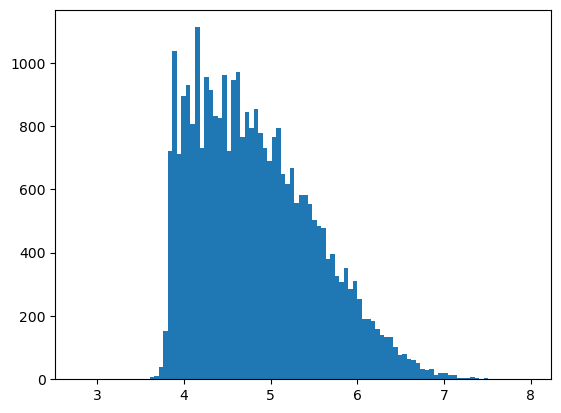

In [21]:
import matplotlib.pyplot as plt

plt.hist(np.log(raw_data.groupby('user').item.count()), bins=100)
plt.show()

In [23]:
np.exp(5)

148.4131591025766

In [25]:
raw_data.shape

(5154471, 3)

In [381]:
# Shuffle User Indices
unique_uid = user_activity.user # 아무리봐도 여기 이상한데?
print("(BEFORE) unique_uid:",unique_uid)
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid)

n_users = unique_uid.size #31360
n_heldout_users = 3000


# Split Train/Validation/Test User Indices
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)] # val 3000명
te_users = unique_uid[(n_users - n_heldout_users):] # test 3000명

tr_users = unique_uid[:(n_users - n_heldout_users)]
vd_users = unique_uid[(n_users - n_heldout_users): (n_users - n_heldout_users)] # val 3000명

#주의: 데이터의 수가 아닌 사용자의 수입니다!
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))

(BEFORE) unique_uid: 0            11
1            14
2            18
3            25
4            31
          ...  
31355    138473
31356    138475
31357    138486
31358    138492
31359    138493
Name: user, Length: 31360, dtype: int64
(AFTER) unique_uid: 6392      27968
15438     67764
603        2581
18877     82969
31197    137831
          ...  
30685    135379
28589    125855
9580      41891
3571      15720
3861      17029
Name: user, Length: 31360, dtype: int64
훈련 데이터에 사용될 사용자 수: 28360
검증 데이터에 사용될 사용자 수: 0
테스트 데이터에 사용될 사용자 수: 3000


In [5]:
raw_data.info()

NameError: name 'raw_data' is not defined

In [382]:
##훈련 데이터에 해당하는 아이템들
#Train는 25360명만 사용
train_plays = raw_data.loc[raw_data['user'].isin(tr_users)] # index 아닌 user 번호 기준 검색 -> unique_uid user 번호로 바꿔야 해!

##아이템 ID
unique_sid = pd.unique(train_plays['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

#Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)



train_data = numerize(train_plays, profile2id, show2id)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)


vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te, profile2id, show2id)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

test_data_tr = numerize(test_plays_tr, profile2id, show2id)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

test_data_te = numerize(test_plays_te, profile2id, show2id)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

inf_data = raw_data[['user','item']].copy()
inf_data = numerize(inf_data, profile2id, show2id)
inf_data.to_csv(os.path.join(pro_dir, 'inference.csv'), index=False)

print("Done!")

ValueError: No objects to concatenate

In [383]:
#데이터 셋 확인
print(train_data)
print(vad_data_tr)
print(vad_data_te)
# print(test_data_tr)
# print(test_data_te)

  (0, 17)	1.0
  (0, 40)	1.0
  (0, 41)	1.0
  (0, 46)	1.0
  (0, 70)	1.0
  (0, 78)	1.0
  (0, 79)	1.0
  (0, 80)	1.0
  (0, 82)	1.0
  (0, 85)	1.0
  (0, 198)	1.0
  (0, 200)	1.0
  (0, 233)	1.0
  (0, 260)	1.0
  (0, 264)	1.0
  (0, 266)	1.0
  (0, 269)	1.0
  (0, 270)	1.0
  (0, 271)	1.0
  (0, 272)	1.0
  (0, 285)	1.0
  (0, 287)	1.0
  (0, 292)	1.0
  (0, 294)	1.0
  (0, 308)	1.0
  :	:
  (25359, 1429)	1.0
  (25359, 1447)	1.0
  (25359, 1794)	1.0
  (25359, 1872)	1.0
  (25359, 2436)	1.0
  (25359, 2669)	1.0
  (25359, 2776)	1.0
  (25359, 2777)	1.0
  (25359, 2860)	1.0
  (25359, 2882)	1.0
  (25359, 3041)	1.0
  (25359, 3063)	1.0
  (25359, 3101)	1.0
  (25359, 3247)	1.0
  (25359, 3340)	1.0
  (25359, 3886)	1.0
  (25359, 3956)	1.0
  (25359, 4293)	1.0
  (25359, 4328)	1.0
  (25359, 4492)	1.0
  (25359, 4606)	1.0
  (25359, 4915)	1.0
  (25359, 4946)	1.0
  (25359, 5026)	1.0
  (25359, 6637)	1.0
  (0, 17)	1.0
  (0, 46)	1.0
  (0, 79)	1.0
  (0, 82)	1.0
  (0, 116)	1.0
  (0, 149)	1.0
  (0, 159)	1.0
  (0, 196)	1.0
  (0, 198)	1.

##3. 데이터 로더 설정

In [384]:

class DataLoader(): # 존재하지도 않는 user가 sparse matrix 상에 포함됨
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):

        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist. Run data.py"

        self.n_items = self.load_n_items()

    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        elif datatype == 'inference':
            return self._load_inf_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test, inference]")

    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items

    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')

        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items)) # uid,sid에만 1 채우고 나머지는 모두 0을 채우는 sparse interaction matrix
        return data

    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        
        return data_tr, data_te
    
    def _load_inf_data(self, datatype='inference'):
        inf_path = os.path.join(self.pro_dir, 'inference.csv')

        data_inf = pd.read_csv(inf_path)

        n_rows = data_inf.uid.nunique()
        n_cols = data_inf.sid.nunique()

        rows = data_inf['uid']
        cols = data_inf['sid']

        data_inf = sparse.csr_matrix((np.ones_like(rows),
                                    (rows, cols)), dtype='float64', shape=(n_rows, n_cols))

        return data_inf

## 4. 모델정의



In [409]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


#이미 완성된 MultiDAE의 코드를 참고하여 그 아래 MultiVAE의 코드를 완성해보세요!
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input):
        # h = F.normalize(input)
        h = self.drop(input)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)



class MultiVAE(nn.Module):
    """
    Container module for Multi-VAE.

    Multi-VAE : Variational Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1] # default: 대칭 구조

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout)
        self.init_weights()

    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def encode(self, input):
        # h = F.normalize(input)
        h = self.drop(input)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else: #
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar): # latent factor(모수) 조정
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) # std와 동일 모양의 N(0,1)난수생성
            return eps.mul(std).add_(mu) # train: 난수*std + mu
        else:
            return mu # val/test: mu

    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)




def loss_function_vae(recon_x, x, mu, logvar, anneal=1.0):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1)) # softmax: multinomial의 loss
    # BCE = torch.nn.BCEWithLogitsLoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)) # 

    return BCE + anneal * KLD

def loss_function_dae(recon_x, x):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    # BCE = torch.nn.BCEWithLogitsLoss(reduction='sum')(recon_x, x)
    return BCE


In [398]:

def sparse2torch_sparse(data): # encoder F.normalize에서 대신 활용
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0] # n_users
    features = data.shape[1] # n_items
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1)) # 유저별로 interaction 수만큼 normalize
    # row_norms_inv = 1 / np.linalg.norm(data, axis=1) # 유저별로 interaction 수만큼 normalize
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return torch.FloatTensor(t.to_dense())

def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())


def train(model, criterion, optimizer, is_VAE = False):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count

    np.random.shuffle(idxlist)

    for batch_idx, start_idx in enumerate(range(0, N, args.batch_size)):
        end_idx = min(start_idx + args.batch_size, N)
        data = train_data[idxlist[start_idx:end_idx]] # 여기의 train_data: sparse interaction matrix 형태
        data = naive_sparse2tensor(data).to(device)
        # data = sparse2torch_sparse(data).to(device)
        optimizer.zero_grad()

        if is_VAE:
          if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap,
                            1. * update_count / args.total_anneal_steps)
          else:
              anneal = args.anneal_cap

          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data)

          loss = criterion(recon_batch, data, mu, logvar, anneal)
        else:
          recon_batch = model(data)
          loss = criterion(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        update_count += 1

        if batch_idx % args.log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, args.batch_size)),
                        elapsed * 1000 / args.log_interval,
                        train_loss / args.log_interval))


            start_time = time.time()
            train_loss = 0.0


def evaluate(model, criterion, data_tr, data_te, is_VAE=False):
    # Turn on evaluation mode
    model.eval()
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    total_val_loss_list = []
    n100_list = []
    r20_list = []
    r50_list = []

    with torch.no_grad():
        for start_idx in range(0, e_N, args.batch_size):
            end_idx = min(start_idx + args.batch_size, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]

            data_tensor = naive_sparse2tensor(data).to(device)
            # data_tensor = sparse2torch_sparse(data).to(device)
            if is_VAE :

              if args.total_anneal_steps > 0:
                  anneal = min(args.anneal_cap,
                                1. * update_count / args.total_anneal_steps)
              else:
                  anneal = args.anneal_cap

              recon_batch, mu, logvar = model(data_tensor)

              loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)

            else :
              recon_batch = model(data_tensor)
              loss = criterion(recon_batch, data_tensor)

            total_val_loss_list.append(loss.item())

            # Exclude examples from training set
            recon_batch = recon_batch.cpu().numpy()
            recon_batch[data.nonzero()] = -np.inf

            n100 = NDCG_binary_at_k_batch(recon_batch, heldout_data, 100)
            r20 = Recall_at_k_batch(recon_batch, heldout_data, 20)
            r50 = Recall_at_k_batch(recon_batch, heldout_data, 50)
            # top10 = torch.topk(recon_batch)

            n100_list.append(n100)
            r20_list.append(r20)
            r50_list.append(r50)

    n100_list = np.concatenate(n100_list)
    r20_list = np.concatenate(r20_list)
    r50_list = np.concatenate(r50_list)

    return np.nanmean(total_val_loss_list), np.nanmean(n100_list), np.nanmean(r20_list), np.nanmean(r50_list)


## Metric 정의

In [399]:
import bottleneck as bn
import numpy as np

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    Normalized Discounted Cumulative Gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)

    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

## MultiDAE 테스트

In [400]:

###############################################################################
# Load data
###############################################################################

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################

p_dims = [200, 600, n_items]
model = MultiDAE(p_dims).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
criterion = loss_function_dae

###############################################################################
# Training code
###############################################################################

best_n100 = -np.inf
update_count = 0

In [401]:
for epoch in range(1, args.epochs+40):
    epoch_start_time = time.time()
    train(model, criterion, optimizer, is_VAE=False)
    val_loss, n100, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=False)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the n100 is the best we've seen so far.
    if n100 > best_n100:
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        best_n100 = n100
        best_epoch = epoch



# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss, n100, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=False)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r20, r50))
print('=' * 89)
print('best epoch:', best_epoch)

/opt/ml/miniconda3/envs/movie/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 1.66s | valid loss 259683.58 | n100 0.262 | r20 0.192 | r50 0.238
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 1.50s | valid loss 253584.77 | n100 0.262 | r20 0.191 | r50 0.238
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 1.53s | valid loss 236254.58 | n100 0.263 | r20 0.193 | r50 0.240
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 1.53s | valid loss 231153.55 | n100 0.264 | r20 0.191 | r50 0.24

## MultiVAE 테스트 (TODO)

위의 MultiVAE 모델 코드, train, evaluate 함수를 완성하여, 아래 훈련 코드가 정상적으로 동작하도록 해보세요!

In [402]:
###############################################################################
# Load data
###############################################################################

loader = DataLoader(args.data)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0] # n_users
idxlist = list(range(N)) # 유저들 묶음을 batch로

###############################################################################
# Build the model
###############################################################################

p_dims = [200, 600, n_items]
model = MultiVAE(p_dims).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)
criterion = loss_function_vae

###############################################################################
# Training code
###############################################################################

best_n100 = -np.inf
update_count = 0

In [403]:
for epoch in range(1, args.epochs + 40):
    epoch_start_time = time.time()
    train(model, criterion, optimizer, is_VAE=True)
    val_loss, n100, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=True)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the n100 is the best we've seen so far.
    if n100 > best_n100:
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        best_n100 = n100
        best_epoch = epoch
        



# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss, n100, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=True)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r20, r50))
print('=' * 89)
print('best epoch:', best_epoch)

/opt/ml/miniconda3/envs/movie/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 1.68s | valid loss 257870.44 | n100 0.259 | r20 0.191 | r50 0.236
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 1.57s | valid loss 244882.44 | n100 0.262 | r20 0.189 | r50 0.238
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 1.61s | valid loss 237222.62 | n100 0.260 | r20 0.190 | r50 0.239
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 1.55s | valid loss 234359.27 | n100 0.263 | r20 0.190 | r50 0.23

## Required Package

- numpy==1.23.5
- pandas==1.5.3
- torch==2.1.0

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.



# Inference

전체 학습 -> inference

In [96]:
total_N = raw_data.user.nunique()
idx_list = np.arange(total_N)

id2show = {v:k for k,v in show2id.items()}
id2profile = {v:k for k,v in profile2id.items()}

In [410]:
args.save

'model_total.pt'

In [340]:
def inference(model, criterion, data, is_VAE=False):
   
# Load the best saved model.
    with open(args.save, 'rb') as f:
      model = torch.load(f)
    
    # turn on eval mode
    model.eval()
    global update_count
    idxlist = list(range(data.shape[0]))
    N = data.shape[0]
    total_topk = []
    result = pd.DataFrame()

    with torch.no_grad():
        for start_idx in range(0, N, args.batch_size):
            end_idx = min(start_idx + args.batch_size, N)
            batch = data[idxlist[start_idx:end_idx]]

            # data_tensor = naive_sparse2tensor(data).to(device)
            data_tensor = sparse2torch_sparse(batch).to(device)
            if is_VAE :

              if args.total_anneal_steps > 0:
                  anneal = min(args.anneal_cap,
                                1. * update_count / args.total_anneal_steps)
              else:
                  anneal = args.anneal_cap

              recon_batch, mu, logvar = model(data_tensor)

            else :
              recon_batch = model(data_tensor)

            # Exclude examples from training set
            recon_batch[batch.nonzero()] = -1e9

            topk = torch.topk(input=recon_batch, k=10)
            batch_topk = list(topk.indices.reshape(-1).detach().cpu().numpy())
          
            total_topk.extend(batch_topk)


    result['user'] = np.repeat(np.arange(31360),10)
    result['item'] = total_topk

    result['user'] = result['user'].apply(lambda x: id2profile[x])
    result['item'] = result['item'].apply(lambda x: id2show[x])
    
    return result.sort_values('user').reset_index(drop=True)


In [375]:
def retrain(model, criterion, optimizer, train_data=data_inf, is_VAE = False):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count
    N = train_data.shape[0]
    idxlist = np.arange(N)

    np.random.shuffle(idxlist)

    for batch_idx, start_idx in enumerate(range(0, N, args.batch_size)):
        end_idx = min(start_idx + args.batch_size, N)
        batch = train_data[idxlist[start_idx:end_idx]] # 여기의 train_data: sparse interaction matrix 형태
        data = naive_sparse2tensor(batch).to(device)
        # data = sparse2torch_sparse(batch).to(device)
        optimizer.zero_grad()

        if is_VAE:
          if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap,
                            1. * update_count / args.total_anneal_steps)
          else:
              anneal = args.anneal_cap

          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data)

          loss = criterion(recon_batch, data, mu, logvar, anneal)
        else:
          recon_batch = model(data)
          loss = criterion(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        update_count += 1

        if batch_idx % args.log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, args.batch_size)),
                        elapsed * 1000 / args.log_interval,
                        train_loss / args.log_interval))


            start_time = time.time()
            train_loss = 0.0

In [405]:
p_dims = [200, 600, n_items]
model = MultiVAE(p_dims).to(device)
loader = DataLoader(args.data)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=args.wd)
criterion = loss_function_vae

In [406]:
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader._load_tr_te_data('test')
data_inf = loader.load_data('inference')

N = train_data.shape[0]
idx_list = np.arange(N)

best_n100 = -np.inf
for epoch in range(1, args.epochs + 40):
    epoch_start_time = time.time()
    # retrain(model, criterion, optimizer, data_inf, is_VAE=True)
    train(model, criterion, optimizer, is_VAE=True)
    val_loss, n100, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=True)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the n100 is the best we've seen so far.
    if n100 > best_n100:
        with open('model_total.pt', 'wb') as f:
            torch.save(model, f)
        best_n100 = n100
        best_epoch=epoch



# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss, n100, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=True)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r20, r50))
print('=' * 89)
print('best epoch:', best_epoch)

/opt/ml/miniconda3/envs/movie/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 1.62s | valid loss 257006.02 | n100 0.261 | r20 0.191 | r50 0.236
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 1.56s | valid loss 241311.42 | n100 0.263 | r20 0.191 | r50 0.239
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 1.49s | valid loss 235747.03 | n100 0.262 | r20 0.190 | r50 0.240
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 1.51s | valid loss 233817.99 | n100 0.263 | r20 0.192 | r50 0.24

In [407]:
args.save='model_total.pt'
result = inference(model, criterion, data_inf, is_VAE=True)
result.to_csv('multi-vae.csv', index=False)

/opt/ml/miniconda3/envs/movie/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [408]:
result

,user,item
0,11,2329
1,11,72998
2,11,32587
3,11,34405
4,11,4370
...,...,...
313595,138493,8961
313596,138493,1270
313597,138493,2012
313598,138493,32587


In [325]:
result

,user,item
0,11,5218
1,11,8861
2,11,3986
3,11,2054
4,11,4370
...,...,...
313595,138493,4370
313596,138493,589
313597,138493,2011
313598,138493,33615


In [2]:
import json
import pandas as pd
import numpy as np

In [97]:
with open('json_id/id2show.json', 'r') as json_file:
    id2show = json.load(json_file)
id2show = json.loads(id2show)

with open('json_id/id2profile.json', 'r') as json_file:
    id2profile = json.load(json_file)
id2profile = json.loads(id2profile)

with open('json_id/id2show_2.json', 'r') as json_file:
    id2show_2 = json.load(json_file)
id2show_2 = json.loads(id2show_2)

with open('json_id/id2profile_2.json', 'r') as json_file:
    id2profile_2 = json.load(json_file)
id2profile_2 = json.loads(id2profile_2)

In [105]:
id2show.values() == id2show_2.values()

False

In [4]:
from dataloader import DataLoader

loader = DataLoader('../../data/train')

a,b,c,d,e,f,g = loader.data_loading()

In [6]:
from models import EASE

model = EASE(31360, 6807)
print(model.reg_weight)
model.fit(g)
temp = model.rank_all(g)

1100


In [46]:
result = model.predict_new(test_data_tr=e, test_data_te=f)
result[e.nonzero()] = -np.inf

In [51]:
from metrics import NDCG_binary_at_k_batch, Recall_at_k_batch

len(Recall_at_k_batch(result, f, 10))

3000

In [7]:
result = pd.DataFrame()

result['user'] = np.repeat(np.arange(31360),10)
result['item'] = temp.reshape(-1)

result['user'] = result['user'].apply(lambda x: id2profile[str(x)])
result['item'] = result['item'].apply(lambda x: id2show[str(x)])

result = result.sort_values('user')

In [8]:
result = pd.read_csv('submission/EASE_240214_065919.csv')

In [14]:
result['new'] = temp.reshape(-1)
result['new'] = result['new'].apply(lambda x: id2show[str(x)])

In [17]:
result['new_2'] = temp.reshape(-1)
result['new_2'] = result['new_2'].apply(lambda x: id2show_2[str(x)])

In [19]:
result['temp'] = temp.reshape(-1)
result

,user,item,new,new_2,temp
0,11,34048,1193,1193,604
1,11,2571,1208,1208,844
2,11,260,3949,3949,599
3,11,5349,260,260,84
4,11,780,750,750,858
...,...,...,...,...,...
313595,138493,4973,2081,2081,1151
313596,138493,4306,6942,6942,564
313597,138493,3081,1270,1270,72
313598,138493,356,899,899,474


In [21]:
a = pd.read_csv('../../data/train/train_ratings.csv')

In [23]:
a.item[:10]

0    4643
1     170
2     531
3     616
4    2140
5    2722
6    2313
7    2688
8    2428
9    3113
Name: item, dtype: int64

In [24]:
result.item[:10]

118256    34048
118257     2571
118258      260
118259     5349
118250      780
118251      480
118252     1270
118253     1214
118254     8644
118255        1
Name: item, dtype: int64

In [20]:
model.full_rank(0)

array([[ 559,  689,  375, 1486, 1049,  707, 1451,   46,  573,  575]])

In [9]:
import numpy as np
import pandas as pd

In [7]:
import json

In [8]:
with open('json_id/id2show.json', 'r') as json_file:
    id2show = json.load(json_file)
id2show = json.loads(id2show)

In [27]:
with open('json_id/id2profile.json', 'r') as json_file:
        id2profile = json.load(json_file)
id2profile = json.loads(id2profile)

In [26]:
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("../../data/train/train_ratings.csv")

In [42]:
temp1 = df.groupby('item').user.count()
temp2 = df.groupby('user').item.count()

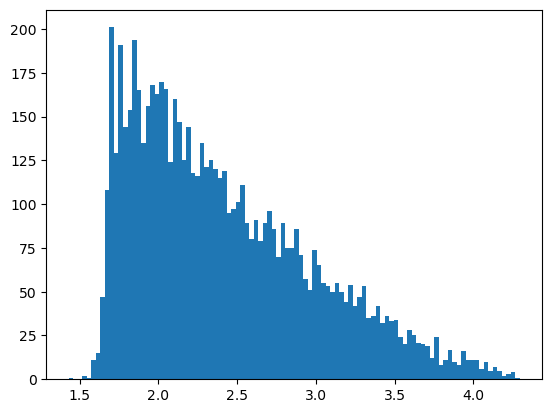

In [63]:
plt.hist(np.log10(temp1), bins=100)
plt.show()

In [41]:
np.exp(3.9)

49.40244910553017

In [33]:
temp1.describe()

count     6807.000000
mean       757.230939
std       1682.973090
min         27.000000
25%         90.000000
50%        197.000000
75%        610.500000
max      19699.000000
Name: user, dtype: float64

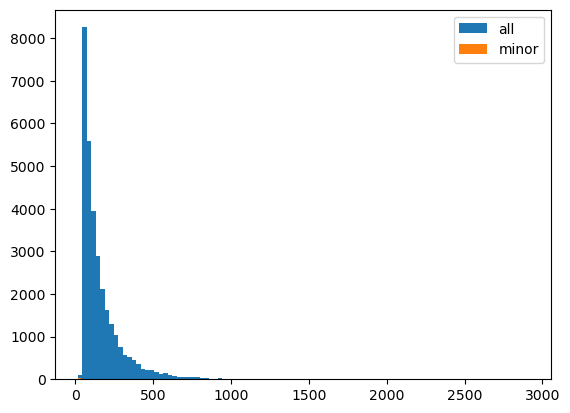

In [56]:
plt.hist(temp2, bins=100, label='all')
plt.hist(temp2[temp2<40], bins=1, label='minor')

plt.legend()
plt.show()

In [64]:
data_inf = pd.read_csv('../../data/train/pro_sg/inference.csv')

data_inf

,uid,sid
0,11825,0
1,11825,1
2,11825,2
3,11825,3
4,11825,4
...,...,...
5154466,10783,423
5154467,10783,1418
5154468,10783,331
5154469,10783,733


In [75]:
t8 = pd.read_csv('../../data/train/pro_sg/train.csv')
t9 = pd.read_csv('../../data/train/pro_sg2/train.csv')

In [80]:
t9.shape[0]- t8.shape[0]

495925

In [84]:
id2show == id2show_2

False

In [85]:
id2profile == id2profile_2

False

In [91]:
id2profile_2

{'0': 27968,
 '1': 67764,
 '2': 2581,
 '3': 82969,
 '4': 137831,
 '5': 48639,
 '6': 97870,
 '7': 40424,
 '8': 46835,
 '9': 79570,
 '10': 94515,
 '11': 137854,
 '12': 11263,
 '13': 47054,
 '14': 37161,
 '15': 90747,
 '16': 127601,
 '17': 39688,
 '18': 3293,
 '19': 18760,
 '20': 35856,
 '21': 102653,
 '22': 44617,
 '23': 82532,
 '24': 81551,
 '25': 63175,
 '26': 102732,
 '27': 123672,
 '28': 97474,
 '29': 98293,
 '30': 85632,
 '31': 129576,
 '32': 457,
 '33': 133514,
 '34': 30737,
 '35': 100288,
 '36': 63791,
 '37': 78521,
 '38': 84886,
 '39': 110828,
 '40': 131016,
 '41': 5393,
 '42': 74051,
 '43': 15628,
 '44': 22246,
 '45': 4055,
 '46': 37939,
 '47': 24856,
 '48': 123019,
 '49': 68906,
 '50': 52155,
 '51': 115183,
 '52': 28748,
 '53': 81158,
 '54': 114566,
 '55': 43796,
 '56': 87294,
 '57': 70546,
 '58': 105479,
 '59': 128762,
 '60': 2161,
 '61': 38516,
 '62': 108458,
 '63': 27281,
 '64': 46054,
 '65': 132914,
 '66': 115134,
 '67': 24853,
 '68': 52391,
 '69': 81884,
 '70': 97183,
 '71